In [2]:
import math
import datetime
import os, sys
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from IPython.display import Audio
import csv

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchsummary import summary

import cv2




# local files
sys.path.insert(0, '../')
import pyClient
import utils
import model
from model import Transition
import training

In [3]:
# Environment parameters
IMSIZE = 128
STACK_SIZE = 4
N_ACTIONS = 3
IP  = "127.0.0.1" # Ip address that the TCP/IP interface listens to
PORT = 13000       # Port number that the TCP/IP interface listens to

environment =  pyClient.Environment(ip = IP, port = PORT, size = IMSIZE) # or choose # DummyEnvironment()


# Model parameters
BATCH_SIZE = 128 #original 128
GAMMA = 0.5
EPS_START = 0.95
EPS_END = 0.05
EPS_DECAY_steps = 4000 
EPS_DECAY = (EPS_START - EPS_END)/EPS_DECAY_steps
REPLAY_START_SIZE =  1500
TARGET_UPDATE = 10 #episodes
DEVICE = 'cuda:0'
MEMORY_CAPACITY = 12000

# agent = model.DoubleDQNAgent(imsize=IMSIZE, 
#                  in_channels=STACK_SIZE,
#                  n_actions=N_ACTIONS,
#                  memory_capacity=MEMORY_CAPACITY,
#                  eps_start=EPS_START,
#                  eps_end=EPS_END,
#                  eps_delta=EPS_DECAY,
#                  gamma_discount = GAMMA,
#                  batch_size = BATCH_SIZE,
#                  device=DEVICE)


# Optimizer Parameters
LR_DQN = 0.0008

# optimizer = optim.Adam(agent.policy_net.parameters(), lr = LR_DQN)

In [4]:
# Image processing
class ImageProcessor(object):
    def __init__(self, phosphene_resolution=None, imsize=128):
        """ @TODO 
        - Extended image processing
        """
        self.imsize = imsize
        if phosphene_resolution is not None:
            self.simulator = utils.PhospheneSimulator(phosphene_resolution=(phosphene_resolution,phosphene_resolution),
                                                     size=(128,128),
                                                     jitter=0.25,
                                                     intensity_var=0.9,
                                                     aperture=.66,
                                                     sigma=0.60,)
        else: 
            self.simulator = None
    
    def __call__(self,state_raw,):
        frame = environment.state2usableArray(state_raw)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.astype('float32')
        if self.simulator is not None:
            frame = self.simulator(frame)
    
        return torch.Tensor(frame / 255.).view(1,1,self.imsize, self.imsize)



In [6]:
## Training parameters 
MAX_EPISODES = 800 # number of episodes (an episode ends after agent hits a box)
MAX_STEPS  = 5e4  # number of optimization steps (each time step the model parameters are updated)
RESET_UPON_END_SIGNAL = {0:False,  # Nothing happened
                         1:True,   # Box collision
                         2:False,   # Wall collision
                         3:False}  # Reached step target
RESET_AFTER_NR_SIDESTEPS = 5


# Training configuration dictionary
cfg = dict()
# cfg['seed']                     = SEED
# cfg['training_condition']       = TRAINING_CONDITION 
cfg['max_episodes']             = MAX_EPISODES
# cfg['model_path']               = MODEL_PATH
cfg['max_steps']                = MAX_STEPS
cfg['target_update']            = TARGET_UPDATE
cfg['stack_size']               = STACK_SIZE
cfg['reset_after_nr_sidesteps'] = RESET_AFTER_NR_SIDESTEPS
cfg['reset_upon_end_signal']    = RESET_UPON_END_SIGNAL
cfg['replay_start_size']        = REPLAY_START_SIZE
# cfg['logfile']                  = LOGFILE

for seed in [0,1,2,3,4]:
    for complexity in ['plain', 'complex']:
        for phosphene_resolution in [None, 50,42,34,26,18,10]:


            # Condition-specific configuration
            cfg['training_condition'] = 0 if complexity == 'plain' else 1 # 0: plain training, 1: complex training, 2: plain testing 3: complex testing
            cfg['seed'] = seed
            torch.manual_seed(seed)
            model_name = 'exp1_{}_phos{}_S{}'.format(complexity,phosphene_resolution,seed)
            print(model_name)
            cfg['logfile'] = 'Out/Exp1/{}_train_stats.csv'.format(model_name)
            cfg['model_path'] = 'Out/Exp1/{}_best_model.pth'.format(model_name)

            # Phosphene simulation
            img_processing = ImageProcessor(phosphene_resolution = phosphene_resolution)

            # Re-initialize model and optimizer
            agent = model.DoubleDQNAgent(imsize=IMSIZE,
                 in_channels=STACK_SIZE,
                 n_actions=N_ACTIONS,
                 memory_capacity=MEMORY_CAPACITY,
                 eps_start=EPS_START,
                 eps_end=EPS_END,
                 eps_delta=EPS_DECAY,
                 gamma_discount = GAMMA,
                 batch_size = BATCH_SIZE,
                 device=DEVICE)

            optimizer = optim.Adam(agent.policy_net.parameters(), lr = LR_DQN)

            # Start training
            training.train(agent, environment, img_processing, optimizer, cfg)
            print('finished training')

exp1_plain_phosNone_S0
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 0, target net updated
episode 10, target net updated
episode 20, target net updated
episode 30, target net updated
episode 40, target net updated
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 50, target net updated
episode 60, target net updated
episode 70, target net updated
episode 80, target net updated
episode 90, target net updated
step count 485 wall_collisions: 0, box_collisions: 40, endless_loops: 0, total_reward: 358.9999999999999
new best model
episode 100, target net updated
episode 110, target net updated
episode 120, target net updated
episode 130, target net updated
episode 140, target net updated
step count 492 wall_collisions: 0, box_collisions: 37, endless_loops: 0, total_reward: 367.29999999999995
new best model
episode 150, target net updated
episode 160, target net updated
episode 170, target

episode 490, target net updated
step count 525 wall_collisions: 0, box_collisions: 0, endless_loops: 0, total_reward: 474.99999999999955
new best model
episode 500, target net updated
episode 510, target net updated
episode 520, target net updated
episode 530, target net updated
finished training
exp1_plain_phos34_S0
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 0, target net updated
episode 10, target net updated
episode 20, target net updated
episode 30, target net updated
episode 40, target net updated
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 50, target net updated
episode 60, target net updated
episode 70, target net updated
episode 80, target net updated
episode 90, target net updated
step count 488 wall_collisions: 0, box_collisions: 48, endless_loops: 0, total_reward: 334.7
new best model
episode 100, target net updated
episode 110, target net updated
episode 120, tar

episode 310, target net updated
episode 320, target net updated
episode 330, target net updated
episode 340, target net updated
step count 517 wall_collisions: 0, box_collisions: 0, endless_loops: 0, total_reward: 475.7999999999997
new best model
episode 350, target net updated
episode 360, target net updated
episode 370, target net updated
episode 380, target net updated
episode 390, target net updated
step count 525 wall_collisions: 0, box_collisions: 0, endless_loops: 0, total_reward: 474.99999999999955
episode 400, target net updated
episode 410, target net updated
episode 420, target net updated
episode 430, target net updated
episode 440, target net updated
step count 525 wall_collisions: 0, box_collisions: 0, endless_loops: 0, total_reward: 474.99999999999966
episode 450, target net updated
episode 460, target net updated
episode 470, target net updated
episode 480, target net updated
episode 490, target net updated
step count 523 wall_collisions: 0, box_collisions: 0, endless_l

episode 470, target net updated
episode 480, target net updated
episode 490, target net updated
step count 518 wall_collisions: 0, box_collisions: 6, endless_loops: 0, total_reward: 457.69999999999965
episode 500, target net updated
episode 510, target net updated
episode 520, target net updated
episode 530, target net updated
episode 540, target net updated
step count 459 wall_collisions: 6, box_collisions: 4, endless_loops: 1, total_reward: 401.4999999999998
episode 550, target net updated
episode 560, target net updated
finished training
exp1_complex_phos50_S0
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 0, target net updated
episode 10, target net updated
episode 20, target net updated
episode 30, target net updated
episode 40, target net updated
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 50, target net updated
episode 60, target net updated
episode 70, target net updated

episode 260, target net updated
episode 270, target net updated
episode 280, target net updated
episode 290, target net updated
step count 518 wall_collisions: 0, box_collisions: 7, endless_loops: 0, total_reward: 454.69999999999965
new best model
episode 300, target net updated
episode 310, target net updated
episode 320, target net updated
episode 330, target net updated
episode 340, target net updated
step count 518 wall_collisions: 0, box_collisions: 4, endless_loops: 0, total_reward: 464.7999999999996
new best model
episode 350, target net updated
episode 360, target net updated
episode 370, target net updated
episode 380, target net updated
episode 390, target net updated
step count 524 wall_collisions: 0, box_collisions: 5, endless_loops: 0, total_reward: 461.1999999999995
episode 400, target net updated
episode 410, target net updated
episode 420, target net updated
episode 430, target net updated
episode 440, target net updated
step count 525 wall_collisions: 0, box_collisions

episode 540, target net updated
step count 529 wall_collisions: 0, box_collisions: 1, endless_loops: 0, total_reward: 471.59999999999957
episode 550, target net updated
episode 560, target net updated
episode 570, target net updated
episode 580, target net updated
episode 590, target net updated
step count 527 wall_collisions: 0, box_collisions: 0, endless_loops: 0, total_reward: 474.7999999999996
new best model
episode 600, target net updated
episode 610, target net updated
episode 620, target net updated
episode 630, target net updated
episode 640, target net updated
finished training
exp1_complex_phos10_S0
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 0, target net updated
episode 10, target net updated
episode 20, target net updated
episode 30, target net updated
episode 40, target net updated
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 50, target net updated
episode 60, ta

episode 60, target net updated
episode 70, target net updated
episode 80, target net updated
episode 90, target net updated
step count 486 wall_collisions: 0, box_collisions: 38, endless_loops: 0, total_reward: 364.8999999999999
new best model
episode 100, target net updated
episode 110, target net updated
episode 120, target net updated
episode 130, target net updated
episode 140, target net updated
step count 525 wall_collisions: 0, box_collisions: 26, endless_loops: 0, total_reward: 398.0999999999997
new best model
episode 150, target net updated
episode 160, target net updated
episode 170, target net updated
episode 180, target net updated
episode 190, target net updated
step count 533 wall_collisions: 0, box_collisions: 10, endless_loops: 0, total_reward: 445.29999999999956
new best model
episode 200, target net updated
episode 210, target net updated
episode 220, target net updated
episode 230, target net updated
episode 240, target net updated
step count 527 wall_collisions: 0, 

episode 510, target net updated
episode 520, target net updated
finished training
exp1_plain_phos26_S1
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 0, target net updated
episode 10, target net updated
episode 20, target net updated
episode 30, target net updated
episode 40, target net updated
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 50, target net updated
episode 60, target net updated
episode 70, target net updated
episode 80, target net updated
episode 90, target net updated
step count 485 wall_collisions: 0, box_collisions: 37, endless_loops: 0, total_reward: 368.0
new best model
episode 100, target net updated
episode 110, target net updated
episode 120, target net updated
episode 130, target net updated
episode 140, target net updated
step count 499 wall_collisions: 0, box_collisions: 23, endless_loops: 0, total_reward: 408.5999999999999
new best model
episode 150, tar

step count 527 wall_collisions: 0, box_collisions: 4, endless_loops: 0, total_reward: 462.7999999999995
new best model
episode 350, target net updated
episode 360, target net updated
episode 370, target net updated
episode 380, target net updated
episode 390, target net updated
step count 518 wall_collisions: 0, box_collisions: 17, endless_loops: 0, total_reward: 424.6999999999996
episode 400, target net updated
episode 410, target net updated
episode 420, target net updated
episode 430, target net updated
episode 440, target net updated
step count 523 wall_collisions: 0, box_collisions: 7, endless_loops: 0, total_reward: 454.19999999999953
episode 450, target net updated
episode 460, target net updated
episode 470, target net updated
episode 480, target net updated
episode 490, target net updated
step count 513 wall_collisions: 0, box_collisions: 14, endless_loops: 0, total_reward: 435.29999999999967
episode 500, target net updated
episode 510, target net updated
episode 520, target n

episode 60, target net updated
episode 70, target net updated
episode 80, target net updated
episode 90, target net updated
step count 520 wall_collisions: 0, box_collisions: 48, endless_loops: 0, total_reward: 331.5
new best model
episode 100, target net updated
episode 110, target net updated
episode 120, target net updated
episode 130, target net updated
episode 140, target net updated
step count 514 wall_collisions: 1, box_collisions: 24, endless_loops: 0, total_reward: 403.1999999999998
new best model
episode 150, target net updated
episode 160, target net updated
episode 170, target net updated
episode 180, target net updated
episode 190, target net updated
step count 469 wall_collisions: 6, box_collisions: 8, endless_loops: 1, total_reward: 369.7999999999997
episode 200, target net updated
episode 210, target net updated
episode 220, target net updated
episode 230, target net updated
episode 240, target net updated
step count 520 wall_collisions: 1, box_collisions: 7, endless_lo

episode 410, target net updated
episode 420, target net updated
episode 430, target net updated
episode 440, target net updated
step count 525 wall_collisions: 0, box_collisions: 1, endless_loops: 0, total_reward: 471.99999999999955
episode 450, target net updated
episode 460, target net updated
episode 470, target net updated
episode 480, target net updated
episode 490, target net updated
step count 521 wall_collisions: 0, box_collisions: 0, endless_loops: 0, total_reward: 475.3999999999995
new best model
episode 500, target net updated
episode 510, target net updated
episode 520, target net updated
episode 530, target net updated
episode 540, target net updated
step count 528 wall_collisions: 0, box_collisions: 0, endless_loops: 0, total_reward: 474.6999999999995
episode 550, target net updated
episode 560, target net updated
finished training
exp1_complex_phos18_S1
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 0, target net updat

episode 710, target net updated
episode 720, target net updated
episode 730, target net updated
episode 740, target net updated
step count 525 wall_collisions: 0, box_collisions: 1, endless_loops: 0, total_reward: 471.99999999999955
finished training
exp1_plain_phosNone_S2
step count 25 wall_collisions: 23, box_collisions: 0, endless_loops: 5, total_reward: -23.7
episode 0, target net updated
episode 10, target net updated
episode 20, target net updated
episode 30, target net updated
episode 40, target net updated
step count 25 wall_collisions: 23, box_collisions: 0, endless_loops: 5, total_reward: -23.7
episode 50, target net updated
episode 60, target net updated
episode 70, target net updated
episode 80, target net updated
episode 90, target net updated
step count 484 wall_collisions: 0, box_collisions: 39, endless_loops: 0, total_reward: 362.0999999999999
new best model
episode 100, target net updated
episode 110, target net updated
episode 120, target net updated
episode 130, targ

episode 370, target net updated
episode 380, target net updated
episode 390, target net updated
step count 526 wall_collisions: 1, box_collisions: 3, endless_loops: 0, total_reward: 466.0999999999997
episode 400, target net updated
episode 410, target net updated
episode 420, target net updated
episode 430, target net updated
episode 440, target net updated
step count 523 wall_collisions: 0, box_collisions: 2, endless_loops: 0, total_reward: 469.1999999999997
episode 450, target net updated
episode 460, target net updated
episode 470, target net updated
episode 480, target net updated
episode 490, target net updated
step count 523 wall_collisions: 0, box_collisions: 2, endless_loops: 0, total_reward: 469.1999999999996
episode 500, target net updated
episode 510, target net updated
episode 520, target net updated
finished training
exp1_plain_phos34_S2
step count 25 wall_collisions: 13, box_collisions: 0, endless_loops: 5, total_reward: -14.7
episode 0, target net updated
episode 10, tar

episode 280, target net updated
episode 290, target net updated
step count 529 wall_collisions: 0, box_collisions: 0, endless_loops: 0, total_reward: 474.59999999999957
new best model
episode 300, target net updated
episode 310, target net updated
episode 320, target net updated
episode 330, target net updated
episode 340, target net updated
step count 521 wall_collisions: 0, box_collisions: 4, endless_loops: 0, total_reward: 463.3999999999997
episode 350, target net updated
episode 360, target net updated
episode 370, target net updated
episode 380, target net updated
episode 390, target net updated
step count 524 wall_collisions: 0, box_collisions: 1, endless_loops: 0, total_reward: 472.09999999999957
episode 400, target net updated
episode 410, target net updated
episode 420, target net updated
episode 430, target net updated
episode 440, target net updated
step count 524 wall_collisions: 0, box_collisions: 1, endless_loops: 0, total_reward: 472.0999999999996
episode 450, target net

episode 460, target net updated
episode 470, target net updated
episode 480, target net updated
episode 490, target net updated
step count 521 wall_collisions: 0, box_collisions: 3, endless_loops: 0, total_reward: 466.3999999999996
episode 500, target net updated
episode 510, target net updated
episode 520, target net updated
episode 530, target net updated
episode 540, target net updated
step count 529 wall_collisions: 0, box_collisions: 0, endless_loops: 0, total_reward: 474.59999999999957
new best model
finished training
exp1_complex_phos50_S2
step count 31 wall_collisions: 29, box_collisions: 0, endless_loops: 5, total_reward: -27.5
episode 0, target net updated
episode 10, target net updated
episode 20, target net updated
episode 30, target net updated
episode 40, target net updated
step count 31 wall_collisions: 29, box_collisions: 0, endless_loops: 5, total_reward: -27.5
episode 50, target net updated
episode 60, target net updated
episode 70, target net updated
episode 80, targ

step count 485 wall_collisions: 2, box_collisions: 8, endless_loops: 1, total_reward: 406.9999999999998
episode 250, target net updated
episode 260, target net updated
episode 270, target net updated
episode 280, target net updated
episode 290, target net updated
step count 529 wall_collisions: 0, box_collisions: 3, endless_loops: 0, total_reward: 466.6999999999996
new best model
episode 300, target net updated
episode 310, target net updated
episode 320, target net updated
episode 330, target net updated
episode 340, target net updated
step count 523 wall_collisions: 0, box_collisions: 1, endless_loops: 0, total_reward: 472.19999999999953
new best model
episode 350, target net updated
episode 360, target net updated
episode 370, target net updated
episode 380, target net updated
episode 390, target net updated
step count 523 wall_collisions: 0, box_collisions: 0, endless_loops: 0, total_reward: 475.1999999999996
new best model
episode 400, target net updated
episode 410, target net up

episode 560, target net updated
episode 570, target net updated
episode 580, target net updated
episode 590, target net updated
step count 523 wall_collisions: 0, box_collisions: 1, endless_loops: 0, total_reward: 472.19999999999953
episode 600, target net updated
episode 610, target net updated
finished training
exp1_complex_phos10_S2
step count 33 wall_collisions: 29, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 0, target net updated
episode 10, target net updated
episode 20, target net updated
episode 30, target net updated
episode 40, target net updated
step count 33 wall_collisions: 29, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 50, target net updated
episode 60, target net updated
episode 70, target net updated
episode 80, target net updated
episode 90, target net updated
step count 476 wall_collisions: 0, box_collisions: 46, endless_loops: 0, total_reward: 341.9
new best model
episode 100, target net updated
episode 110, target net updat

episode 140, target net updated
step count 544 wall_collisions: 1, box_collisions: 20, endless_loops: 0, total_reward: 414.39999999999964
new best model
episode 150, target net updated
episode 160, target net updated
episode 170, target net updated
episode 180, target net updated
episode 190, target net updated
step count 454 wall_collisions: 1, box_collisions: 12, endless_loops: 2, total_reward: 360.4999999999998
episode 200, target net updated
episode 210, target net updated
episode 220, target net updated
episode 230, target net updated
episode 240, target net updated
step count 517 wall_collisions: 0, box_collisions: 5, endless_loops: 0, total_reward: 460.79999999999967
new best model
episode 250, target net updated
episode 260, target net updated
episode 270, target net updated
episode 280, target net updated
episode 290, target net updated
step count 525 wall_collisions: 0, box_collisions: 1, endless_loops: 0, total_reward: 471.99999999999955
new best model
episode 300, target ne

finished training
exp1_plain_phos26_S3
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 0, target net updated
episode 10, target net updated
episode 20, target net updated
episode 30, target net updated
episode 40, target net updated
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 50, target net updated
episode 60, target net updated
episode 70, target net updated
episode 80, target net updated
episode 90, target net updated
step count 484 wall_collisions: 0, box_collisions: 38, endless_loops: 0, total_reward: 365.0999999999999
new best model
episode 100, target net updated
episode 110, target net updated
episode 120, target net updated
episode 130, target net updated
episode 140, target net updated
step count 505 wall_collisions: 0, box_collisions: 31, endless_loops: 0, total_reward: 385.0999999999998
new best model
episode 150, target net updated
episode 160, target net updated
epis

episode 360, target net updated
episode 370, target net updated
episode 380, target net updated
episode 390, target net updated
step count 525 wall_collisions: 0, box_collisions: 1, endless_loops: 0, total_reward: 471.99999999999966
new best model
episode 400, target net updated
episode 410, target net updated
episode 420, target net updated
episode 430, target net updated
episode 440, target net updated
step count 523 wall_collisions: 0, box_collisions: 12, endless_loops: 0, total_reward: 439.19999999999965
episode 450, target net updated
episode 460, target net updated
episode 470, target net updated
episode 480, target net updated
episode 490, target net updated
step count 527 wall_collisions: 0, box_collisions: 1, endless_loops: 0, total_reward: 471.7999999999996
episode 500, target net updated
episode 510, target net updated
episode 520, target net updated
episode 530, target net updated
episode 540, target net updated
step count 530 wall_collisions: 0, box_collisions: 7, endless_

episode 10, target net updated
episode 20, target net updated
episode 30, target net updated
episode 40, target net updated
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 50, target net updated
episode 60, target net updated
episode 70, target net updated
episode 80, target net updated
episode 90, target net updated
step count 484 wall_collisions: 0, box_collisions: 46, endless_loops: 0, total_reward: 341.0999999999998
new best model
episode 100, target net updated
episode 110, target net updated
episode 120, target net updated
episode 130, target net updated
episode 140, target net updated
step count 481 wall_collisions: 3, box_collisions: 28, endless_loops: 1, total_reward: 345.3999999999995
new best model
episode 150, target net updated
episode 160, target net updated
episode 170, target net updated
episode 180, target net updated
episode 190, target net updated
step count 409 wall_collisions: 2, box_collisions: 14, endless_loops:

step count 523 wall_collisions: 0, box_collisions: 1, endless_loops: 0, total_reward: 472.19999999999953
new best model
episode 350, target net updated
episode 360, target net updated
episode 370, target net updated
episode 380, target net updated
episode 390, target net updated
step count 521 wall_collisions: 0, box_collisions: 5, endless_loops: 0, total_reward: 461.49999999999955
episode 400, target net updated
episode 410, target net updated
episode 420, target net updated
episode 430, target net updated
episode 440, target net updated
step count 525 wall_collisions: 0, box_collisions: 2, endless_loops: 0, total_reward: 468.99999999999955
episode 450, target net updated
episode 460, target net updated
episode 470, target net updated
episode 480, target net updated
episode 490, target net updated
step count 525 wall_collisions: 0, box_collisions: 1, endless_loops: 0, total_reward: 471.9999999999996
episode 500, target net updated
episode 510, target net updated
episode 520, target ne

episode 560, target net updated
episode 570, target net updated
episode 580, target net updated
episode 590, target net updated
step count 522 wall_collisions: 0, box_collisions: 7, endless_loops: 0, total_reward: 454.29999999999956
episode 600, target net updated
episode 610, target net updated
episode 620, target net updated
episode 630, target net updated
episode 640, target net updated
step count 514 wall_collisions: 0, box_collisions: 11, endless_loops: 0, total_reward: 443.0999999999997
episode 650, target net updated
episode 660, target net updated
episode 670, target net updated
episode 680, target net updated
episode 690, target net updated
step count 523 wall_collisions: 0, box_collisions: 2, endless_loops: 0, total_reward: 469.19999999999953
new best model
episode 700, target net updated
episode 710, target net updated
episode 720, target net updated
episode 730, target net updated
episode 740, target net updated
step count 515 wall_collisions: 0, box_collisions: 14, endless

episode 240, target net updated
step count 528 wall_collisions: 1, box_collisions: 2, endless_loops: 0, total_reward: 467.7999999999996
new best model
episode 250, target net updated
episode 260, target net updated
episode 270, target net updated
episode 280, target net updated
episode 290, target net updated
step count 531 wall_collisions: 0, box_collisions: 5, endless_loops: 0, total_reward: 460.49999999999955
episode 300, target net updated
episode 310, target net updated
episode 320, target net updated
episode 330, target net updated
episode 340, target net updated
step count 521 wall_collisions: 0, box_collisions: 7, endless_loops: 0, total_reward: 457.6999999999997
episode 350, target net updated
episode 360, target net updated
episode 370, target net updated
episode 380, target net updated
episode 390, target net updated
step count 469 wall_collisions: 2, box_collisions: 8, endless_loops: 1, total_reward: 397.5999999999998
episode 400, target net updated
episode 410, target net 

episode 110, target net updated
episode 120, target net updated
episode 130, target net updated
episode 140, target net updated
step count 518 wall_collisions: 2, box_collisions: 21, endless_loops: 0, total_reward: 411.9999999999998
new best model
episode 150, target net updated
episode 160, target net updated
episode 170, target net updated
episode 180, target net updated
episode 190, target net updated
step count 384 wall_collisions: 3, box_collisions: 7, endless_loops: 2, total_reward: 307.0000000000001
episode 200, target net updated
episode 210, target net updated
episode 220, target net updated
episode 230, target net updated
episode 240, target net updated
step count 530 wall_collisions: 0, box_collisions: 0, endless_loops: 0, total_reward: 474.49999999999955
new best model
episode 250, target net updated
episode 260, target net updated
episode 270, target net updated
episode 280, target net updated
episode 290, target net updated
step count 527 wall_collisions: 0, box_collision

episode 420, target net updated
episode 430, target net updated
episode 440, target net updated
step count 525 wall_collisions: 0, box_collisions: 1, endless_loops: 0, total_reward: 471.99999999999955
new best model
episode 450, target net updated
episode 460, target net updated
episode 470, target net updated
episode 480, target net updated
episode 490, target net updated
step count 524 wall_collisions: 1, box_collisions: 2, endless_loops: 0, total_reward: 468.1999999999995
episode 500, target net updated
episode 510, target net updated
episode 520, target net updated
episode 530, target net updated
episode 540, target net updated
step count 525 wall_collisions: 0, box_collisions: 0, endless_loops: 0, total_reward: 474.99999999999955
new best model
episode 550, target net updated
finished training
exp1_complex_phos50_S4
step count 475 wall_collisions: 0, box_collisions: 51, endless_loops: 0, total_reward: 327.0
new best model
episode 0, target net updated
episode 10, target net update

episode 210, target net updated
episode 220, target net updated
episode 230, target net updated
episode 240, target net updated
step count 488 wall_collisions: 1, box_collisions: 3, endless_loops: 1, total_reward: 422.5999999999997
new best model
episode 250, target net updated
episode 260, target net updated
episode 270, target net updated
episode 280, target net updated
episode 290, target net updated
step count 528 wall_collisions: 0, box_collisions: 0, endless_loops: 0, total_reward: 474.6999999999995
new best model
episode 300, target net updated
episode 310, target net updated
episode 320, target net updated
episode 330, target net updated
episode 340, target net updated
step count 525 wall_collisions: 0, box_collisions: 4, endless_loops: 0, total_reward: 462.99999999999955
episode 350, target net updated
episode 360, target net updated
episode 370, target net updated
episode 380, target net updated
episode 390, target net updated
step count 527 wall_collisions: 0, box_collisions

episode 510, target net updated
episode 520, target net updated
episode 530, target net updated
episode 540, target net updated
step count 523 wall_collisions: 0, box_collisions: 5, endless_loops: 0, total_reward: 460.1999999999995
episode 550, target net updated
episode 560, target net updated
episode 570, target net updated
episode 580, target net updated
episode 590, target net updated
step count 525 wall_collisions: 0, box_collisions: 1, endless_loops: 0, total_reward: 471.99999999999955
new best model
finished training
exp1_complex_phos10_S4
step count 475 wall_collisions: 0, box_collisions: 51, endless_loops: 0, total_reward: 327.0
new best model
episode 0, target net updated
episode 10, target net updated
episode 20, target net updated
episode 30, target net updated
episode 40, target net updated
step count 475 wall_collisions: 0, box_collisions: 51, endless_loops: 0, total_reward: 327.0
episode 50, target net updated
episode 60, target net updated
episode 70, target net updated

## Debugging:

#### Visualize replay memory 

In [ ]:
# EXAMPLES = 10

# i = 0
# bad_choices = [(state, action, next_state,reward) for (state, action, next_state,reward) in agent.memory.memory]# if reward<0 and action ==0]
# # for state, action, next_state, reward in agent.memory.memory[:EXAMPLES]:
# for state, action, next_state, reward in bad_choices[:EXAMPLES]:
#     i+=1
    
#     plt.figure(figsize = (10,10), dpi=200)
#     img = torch.cat([state[0,t,...] for t in range(STACK_SIZE)],dim=1)
#     if next_state is not None:
#         img = torch.cat([img, next_state[0,-1,...]],dim=1)
#         plt.axvline(x=STACK_SIZE*IMSIZE,color='r')
#     plt.imshow(img.detach().cpu().numpy())
#     plt.title('Action: {}, Reward {}'.format(action.item(),reward.item()))
#     plt.axis('off')
#     plt.ylabel('frames >')
#     plt.xlabel('state | next state')
#     plt.show()
    
# # plt.tight_layout()


#### Inspecting q-value predictions

In [ ]:
# state_action_values, expected_state_action_values = agent.forward()
# transitions = agent.memory.sample(agent.batch_size)
# # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
# # detailed explanation). This converts batch-array of Transitions
# # to Transition of batch-arrays.
# batch = Transition(*zip(*transitions))

# # Compute a mask of non-final states and concatenate the batch elements
# # (a final state would've been the one after which simulation ended)
# non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
#                                       batch.next_state)), device=agent.device, dtype=torch.bool)
# non_final_next_states = torch.cat([s for s in batch.next_state
#                                             if s is not None])
# state_batch = torch.cat(batch.state)
# action_batch = torch.cat(batch.action)
# reward_batch = torch.cat(batch.reward)

# # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
# # columns of actions taken. These are the actions which would've been taken
# # for each batch state according to policy_net
# pred = agent.policy_net(state_batch)

# EXAMPLES = 50

# actions = action_batch[:EXAMPLES].detach().cpu().numpy()
# rewards = reward_batch[:EXAMPLES].detach().cpu().numpy()
# predicted = pred[:EXAMPLES].detach().cpu().numpy().squeeze()
# obtained = np.zeros((EXAMPLES,3))
# for i in range(EXAMPLES):
#     obtained[i,actions[i]] = rewards[i]

# plt.figure(figsize=(10,10),dpi=100)
# plt.subplot(1,2,1)
# plt.imshow(predicted)
# plt.subplot(1,2,2)
# plt.imshow(obtained)
# plt.show()

#### Visualize an episode

In [ ]:
# Reset environment at start of episode
seed = torch.randint(250,(1,)).item()
_, _, _ = environment.setRandomSeed(seed)
_, _, _ = environment.reset(cfg['training_condition'])

# Create an empty frame stack and fill it with frames
frame_stack = utils.FrameStack(stack_size=cfg['stack_size'] )
for _ in range(cfg['stack_size'] ):
    _, _, frame_raw = environment.step(0)
    frame = img_processing(frame_raw).to(agent.device) 
    state = frame_stack.update_with(frame)

In [ ]:
# for t in count(): 

#     agent.policy_net.eval()
#     # Agent performs a step (based on the current state) and obtains next state
#     action = agent.select_action(state)
#     end, reward, frame_raw = environment.step(action.item())
#     agent_died = cfg['reset_upon_end_signal'][end] # or side_steps > cfg['reset_after_nr_sidesteps']
#     frame = img_processing(frame_raw).to(agent.device)
#     next_state = frame_stack.update_with(frame) if not agent_died else None
#     pred = agent.policy_net(state).argmax(axis=1)
    
#     # Interpret reward signal
#     if reward > 100:
#         reward = -(reward -100)
#     reward /= 10
    
#     # Visualize state and print pred, action and reward
#     plt.figure(figsize = (10,10), dpi=200)
#     img = torch.cat([state[0,t,...] for t in range(STACK_SIZE)],dim=1)
#     if next_state is not None:
#         img = torch.cat([img, next_state[0,-1,...]],dim=1)
#         plt.axvline(x=STACK_SIZE*IMSIZE,color='r')
#     plt.imshow(img.detach().cpu().numpy())
#     plt.title('Action: {}, Reward {}'.format(action.item(),reward))
#     plt.axis('off')
#     plt.ylabel('frames >')
#     plt.xlabel('state | next state')
#     plt.show()
#     print('Pred: {}'.format(pred.item()))
#     print('Action: {}'.format(action.item()))
#     print('Reward: {}\n'.format(reward))

#     # the episode ends here if agent performed any 'lethal' action (specified in RESET_UPON_END_SIGNAL)
#     if agent_died:
#         break
#     else:
#         state = next_state


#### Toy environment for debugging

In [ ]:
# class DummyEnvironment:
#     def __init__(self, ip = "127.0.0.1", port = 13000, size = 128, channels=16):
#         self.size = size
#         self.channels = channels
#         self._maxSteps = 100
#         self.reset()
 
#     def reset(self, kind=0):
#         self._state = 1
#         self._steps = 0
#         return self._receive()

#     def step(self, action):
#         self._state = -self._state
#         self._steps += 1
#         return self._receive(action)
    
#     def setRandomSeed(self, action):
#         return self._receive()

#     def _receive(self,action=0):
#         end    = 0 if self._steps < self._maxSteps else 3
#         reward = {0:-self._state, 1:self._state, 2:-2}[action]
#         state  = [150-100*self._state for _ in range(262144)] # raw state
#         return end, reward, state
    
#     def state2arrays(self,state):
#         if self.channels == 3:
#             return {'colors' : self.state2usableArray(state),}
        
#         else:
#             state  = np.array(state, "uint8").reshape(self.size, self.size, self.channels)
#             arrays = {'colors' : state[...,:3],
#                     'objseg' : state[...,3:6],
#                     'semseg': state[...,6:9],
#                     'normals'   : state[...,9:12],
#                     'flow'   : state[...,12:15],
#                     'depth'  : state[...,15]}
#             return arrays
    
#     def state2usableArray(self, state):
#         return np.array(state, "uint8").reshape(self.size, self.size, 16)[...,:3]

## Validation:

#### Fast evaluation of trained model

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

MODEL_NAME = 'exp1_plain_phosNone_S0'

stats = pd.read_csv('./Out/Exp1/{}_train_stats.csv'.format(MODEL_NAME))

plt.figure(figsize = (16,4),dpi=200)
plt.subplot(1,2,1)
sns.lineplot(data= stats.loc[stats.validation==0],x='episode', y='reward')
plt.plot(np.convolve(stats.loc[stats.validation==0].reward,np.ones(10)/10,mode='valid'))
plt.title('training performance')
plt.legend(['training_reward', 'running average (N=10)'])
plt.subplot(1,2,2)
sns.lineplot(data= stats.loc[stats.validation==1],x='episode', y='reward')
plt.title('validation performance')
plt.legend(['validation_reward'])
plt.show()

plt.figure(figsize = (16,4))
sns.lineplot(data= stats.loc[stats.validation==0],x='episode', y='train_loss')
plt.title('training curves')
plt.legend(['Train Loss'])

plt.figure(figsize = (16,4))
sns.lineplot(data= stats.loc[stats.validation==0],x='episode', y='epsilon')
plt.title('training curves')
plt.legend(['Train Loss'])

FileNotFoundError: [Errno 2] File b'./Out/Exp1/exp1_plain_phosNone_S0_train_stats.csv' does not exist: b'./Out/Exp1/exp1_plain_phosNone_S0_train_stats.csv'

### Further testing and evaluation:

In [1]:
import torch
import cv2
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

# # local files
sys.path.insert(0, '../')
import pyClient
import utils
import model
from model import Transition
from testing import test

#### Run models on test environment:

In [ ]:
# Image processing
class ImageProcessor(object):
    def __init__(self, phosphene_resolution=None, imsize=128):
        """ @TODO 
        - Extended image processing
        """
        self.imsize = imsize
        if phosphene_resolution is not None:
            self.simulator = utils.PhospheneSimulator(phosphene_resolution=(phosphene_resolution,phosphene_resolution),
                                                     size=(128,128),
                                                     jitter=0.25,
                                                     intensity_var=0.9,
                                                     aperture=.66,
                                                     sigma=0.60,)
        else: 
            self.simulator = None
    
    def __call__(self,state_raw,):
        frame = environment.state2usableArray(state_raw)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.astype('float32')
        if self.simulator is not None:
            frame = self.simulator(frame)
    
        return torch.Tensor(frame / 255.).view(1,1,self.imsize, self.imsize)
    
img_processing = ImageProcessor

In [ ]:
# Environment parameters
IMSIZE = 128
STACK_SIZE = 4
N_ACTIONS = 3
IP  = "127.0.0.1" # Ip address that the TCP/IP interface listens to
PORT = 13000       # Port number that the TCP/IP interface listens to

environment = pyClient.Environment(ip = IP, port = PORT, size = IMSIZE) 

# Model parameters
BATCH_SIZE = 128 #original 128
DEVICE = 'cuda:0'

agent = model.DoubleDQNAgent(imsize=IMSIZE,
                 in_channels=STACK_SIZE,
                 n_actions=N_ACTIONS,
                 device=DEVICE)


## Testing parameters 
RESET_UPON_END_SIGNAL = {0:False,  # Nothing happened
                         1:False,   # Box collision
                         2:False,   # Wall collision
                         3:True}  # Reached step target
RESET_AFTER_NR_SIDESTEPS = 5


# Testing configuration dictionary
cfg = dict()
cfg['stack_size']               = STACK_SIZE
cfg['reset_after_nr_sidesteps'] = RESET_AFTER_NR_SIDESTEPS
cfg['reset_upon_end_signal']    = RESET_UPON_END_SIGNAL

test_data = []
for complexity in ['plain', 'complex']:
    for phosphene_resolution in [None, 50,42,34,26,18,10]:
        for seed in [0,1,2,3,4]:
            
            # Condition-specific configuration
            cfg['training_condition']       = 2 if complexity == 'plain' else 3 # 0: plain training, 1: complex training, 2: plain testing 3: complex testing
            model_name = 'exp1_{}_phos{}_S{}'.format(complexity, phosphene_resolution,seed)
            model_path = 'Out/Exp1/{}_best_model.pth'.format(model_name)
            print(model_name)

            # Phosphene simulation
            img_processing = ImageProcessor(phosphene_resolution = phosphene_resolution)

            # Re-initialize model and optimizer
            agent = model.DoubleDQNAgent(imsize=IMSIZE,
                 in_channels=STACK_SIZE,
                 n_actions=N_ACTIONS,
                 device=DEVICE)
            agent.policy_net.load_state_dict(torch.load(model_path,map_location=DEVICE))

            # Testing
            conditions = {'complexity': complexity, 'phosphene_resolution': phosphene_resolution, 'seed' : seed}
            results = test(agent, environment, img_processing, cfg)
            test_data.append({**conditions,**results})
data = pd.DataFrame(test_data)
data.to_csv('Out/Exp1/_test_results.csv', index=False)

In [ ]:
test_data = pd.read_csv('./Out/Exp1/_test_results.csv') 
test_data

In [ ]:
sns.lineplot(data=test_data,x='phosphene_resolution', y='box_collisions', hue='complexity')
plt.show()
sns.lineplot(data=test_data,x='phosphene_resolution', y='wall_collisions', hue='complexity')
plt.show()
sns.lineplot(data=test_data,x='phosphene_resolution', y='cumulative_reward', hue='complexity')

#### Training and validation curves

In [2]:
all_stats = pd.DataFrame()
best_stats = pd.DataFrame()
for complexity in ['plain', 'complex']:
    for phosphene_resolution in [None, 50,42,34,26,18,10]:
        for seed in [0,1,2,3,4]:
            model_name = 'exp1_{}_phos{}_S{}'.format(complexity, phosphene_resolution,seed)
            train_csv = './Out/Exp1_Sep22/{}_train_stats.csv'.format(model_name)
            train_stats = pd.read_csv(train_csv)
            train_stats['complexity'] = complexity
            train_stats['resolution'] = phosphene_resolution
            train_stats['seed'] = seed
            train_stats['model_name'] = model_name
            
            # append all rows
            all_stats = all_stats.append(train_stats,ignore_index=True)
            
            # append only best-performing validation row
            val = train_stats.loc[train_stats.validation==1].reset_index()
            best_stats = best_stats.append(val.iloc[[val.reward.idxmax()]], ignore_index=True)


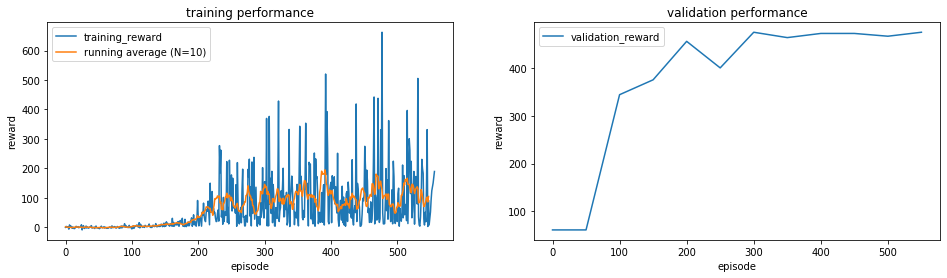

In [3]:
MODEL_NAME = 'exp1_plain_phos18_S2'

stats = all_stats.loc[all_stats.model_name==MODEL_NAME]

plt.figure(figsize = (16,4))
plt.subplot(1,2,1)
sns.lineplot(data= stats.loc[stats.validation==0],x='episode', y='reward')
plt.plot(np.convolve(stats.loc[stats.validation==0].reward,np.ones(10)/10,mode='valid'))
plt.title('training performance')
plt.legend(['training_reward', 'running average (N=10)'])
plt.subplot(1,2,2)
sns.lineplot(data= stats.loc[stats.validation==1],x='episode', y='reward')
plt.title('validation performance')
plt.legend(['validation_reward'])
plt.show()


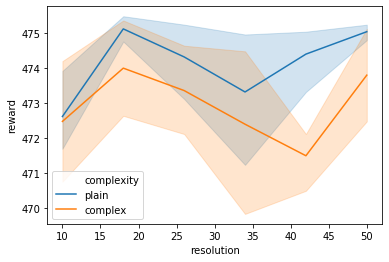

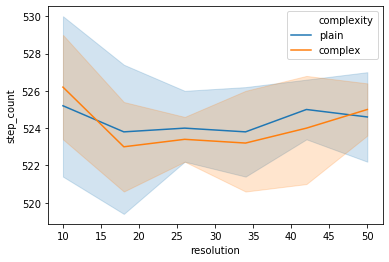

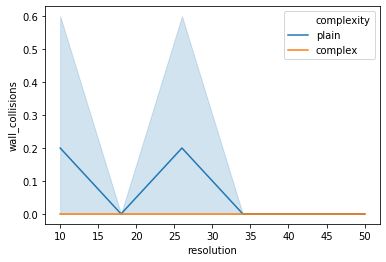

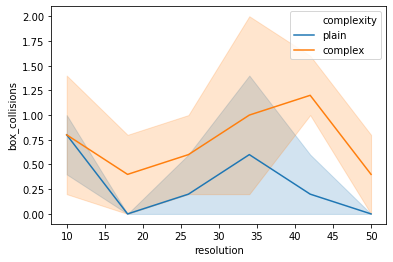

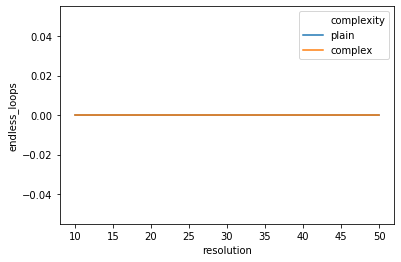

In [4]:
for y in ['reward', 'step_count', 'wall_collisions', 'box_collisions', 'endless_loops']:
    sns.lineplot(data=best_stats, x='resolution',y=y,hue='complexity')
    plt.show()